# Installing Libraries

In [ ]:
%%capture
# Installing libraries without displaying output
!pip install scikit-learn
!pip install missingno
!pip install xgboost
!pip install imbalanced-learn
!pip install fancyimpute
!pip install tensorflow
!pip install tabulate
!pip install statsmodels
!pip install lightgbm
#!pip install yellowbrick
!pip install scikit-optimize
!pip install shap
!pip install treeinterpreter

# Importing Libraries

In [60]:
# Importing the necessary libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
#from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
#from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import numpy as np
from sklearn.feature_selection import RFECV
#from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
#from imblearn.combine import SMOTEENN
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
#from imblearn.over_sampling import SMOTENC
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
#from yellowbrick.features import RFECV
from sklearn.neural_network import MLPClassifier


from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from imblearn.over_sampling import RandomOverSampler
import numpy as np

import lightgbm as lgb

# Functions

In [61]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

def fold_analyzer(classifier, scaler, imputer, X_anx_selected, y_anx, fold=1):
    # Defining the pipeline
    pipeline = Pipeline(steps=[
        ('Scaler', scaler),
        ('Simple', imputer),
        ('Classifier', classifier)
    ])

    # Creating variables for the data
    X = X_anx_selected.values  # Converting DataFrame to numpy array
    y = y_anx.values  # Converting Series to numpy array

    # Initializing stratified k-fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initializing a list to store validation scores for each fold
    f1_macro = []
    f1_class_0 = []
    f1_class_1 = []

    # Initializing variables to store datasets for each fold
    X_train_fold, X_val_fold = None, None
    y_train_fold, y_val_fold = None, None

    # Variable for keeping track of fold number
    fold_number = 1

    # Manual cross-validation
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Fitting the pipeline on the data
        pipeline.fit(X_train, y_train)

        # Making predictions on the validation data
        y_pred = pipeline.predict(X_val)

        # Calculating the F1_macro
        f1_macro.append(f1_score(y_val, y_pred, average='macro'))

        # Calculating the individual F1 scores for both classes
        f1_class_0.append(f1_score(y_val, y_pred, average=None)[0])
        f1_class_1.append(f1_score(y_val, y_pred, average=None)[1])

        print(f"F1_macro for fold {fold_number}: {f1_macro[-1]}")
        print(f"F1_class_0 for fold {fold_number}: {f1_class_0[-1]}")
        print(f"F1_class_1 for fold {fold_number}: {f1_class_1[-1]}")

        # Saving the data for this specific fold
        if fold_number == fold:
            X_train_fold, X_val_fold = X_train, X_val
            y_train_fold, y_val_fold = y_train, y_val
            #Scaled and imputed for SHAP
            X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train_fold), columns=X_anx_selected.columns)
            X_val_scaled = scaler.transform(X_val_fold)
            X_train_imputed = imputer.fit_transform(X_train_scaled)
            X_val_imputed = imputer.transform(X_val_scaled)

        fold_number += 1

    # Fitting the pipeline on the data
    pipeline.fit(X_train_fold, y_train_fold)

    # Making predictions on the validation data
    y_pred = pipeline.predict(X_val_fold)

    # Calculating the F1_macro for this specified fold
    f1_macro_fold = f1_score(y_val_fold, y_pred, average='macro')
    print("Manually extracted fold F1_macro:", f1_macro_fold)

    # Returning the F1_macro for all folds, the F1_macro for this specific fold,
    # and individual F1 scores for each class for each fold
    return f1_macro, f1_class_0, f1_class_1, X_train_fold, X_val_fold, y_train_fold, y_val_fold, X_train_imputed, X_val_imputed


# Dataset preparation

## Loading data

In [62]:
# Anxiety ------------------------------------
# loading the feature engineered variables
anx_data=pd.read_csv('df_anx_t6_2.csv')

# Loading in the data
X_anx = anx_data.iloc[:, :-1]
y_anx = anx_data.iloc[:, -1]

selected_features = ['ucla_t6_sum', 'summary_score_kccq_base', 'eq5d5l_index_t6', 'MCS_t6', 'ImplWeight', 'personality_type_D']
X_anx_selected = X_anx[selected_features]


# Distressed ---------------------------------
# loading the feature engineered variables
dis_data=pd.read_csv('data_2.csv')

# Loading in the data
X_dis = dis_data.iloc[:, :-1]
y_dis = dis_data.iloc[:, -1]

# Removing Redundant features
X_dis = X_dis.drop(X_dis.columns[0], axis=1)

selected_features = ['ucla_t6_sum', 'eq5d5l_index_t6', 'depression_base_score', 'icdc_t6_sum', 'MCS_t6', 'Return_to_function_t6', 'age', 'anxiety_base_score']
X_dis_selected = X_dis[selected_features]


# Stacking on Anxiety dataset

## Defining the model

In [63]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np
import shap

# Defining the preprocessing steps
scaler = RobustScaler()
imputer = SimpleImputer()

# Defining stratified k-fold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

anx_models_comb = [
    ('Random Forest', RandomForestClassifier(class_weight='balanced', max_depth=None, max_features='log2', min_samples_leaf=3, min_samples_split=7, n_estimators=90, random_state=42)),
    ('SVM', SVC(C=1.0, class_weight=None, coef0=0.05, degree=12, gamma='auto', kernel='rbf', max_iter=7000, probability=True, shrinking=True, random_state=42)),
    ('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=5, p=1, weights='uniform', n_jobs=-1)),
    ('XGB', xgb.XGBClassifier(colsample_bytree=0.9, learning_rate=0.4, max_depth=3, min_child_weight=1, n_estimators=162, subsample=0.9, random_state=42, n_jobs=-1)),
]

# Creating a stacking with SVM as the final estimator
svm_model = SVC(C=1.0, kernel='rbf', degree=14, gamma='scale', coef0=0.05, shrinking=True, probability=True, class_weight=None, max_iter=7000, random_state=42)
stacking_clf = StackingClassifier(estimators=anx_models_comb, final_estimator=svm_model, cv=stratified_kfold)

# Extracting the folds
f1_macro, f1_class_0, f1_class_1, X_train_fold, X_val_fold, y_train_fold, y_val_fold, X_train_imputed, X_val_imputed  = fold_analyzer(stacking_clf, scaler, imputer, X_anx_selected, y_anx, fold=1)

# Adding the column names again
X_train_imputed = pd.DataFrame(data=X_train_imputed, columns = X_anx_selected.columns)
X_val_imputed = pd.DataFrame(data=X_val_imputed, columns = X_anx_selected.columns)

F1_macro for fold 1: 0.9229534510433386
F1_class_0 for fold 1: 0.9887640449438202
F1_class_1 for fold 1: 0.8571428571428571
F1_macro for fold 2: 0.9111111111111112
F1_class_0 for fold 2: 0.9888888888888889
F1_class_1 for fold 2: 0.8333333333333334
F1_macro for fold 3: 0.9587451654490761
F1_class_0 for fold 3: 0.994413407821229
F1_class_1 for fold 3: 0.9230769230769231
F1_macro for fold 4: 0.7587607922803453
F1_class_0 for fold 4: 0.9720670391061452
F1_class_1 for fold 4: 0.5454545454545454
F1_macro for fold 5: 1.0
F1_class_0 for fold 5: 1.0
F1_class_1 for fold 5: 1.0
Manually extracted fold F1_macro: 0.9229534510433386


In [64]:
# Fitting the model on the data
stacking_clf.fit(X_train_imputed, y_train_fold) #Fitting the model

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('Random Forest',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_features='log2',
                                                       min_samples_leaf=3,
                                                       min_samples_split=7,
                                                       n_estimators=90,
                                                       random_state=42)),
                               ('SVM',
                                SVC(coef0=0.05, degree=12, gamma='auto',
                                    max_iter=7000, probability=True,
                                    random_state=42)),
                               ('KNN',
                                KN...
                                              learning_rate=0.4, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=3,
                                              max_leaves=None,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=162, n_jobs=-1,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=SVC(coef0=0.05, degree=14, max_iter=7000,
                                       probability=True, random_state=42))

## Global SHAP

### Calculating SHAP Values

In [79]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

explainer_test = shap.Explainer(stacking_clf.predict, X_train_imputed)
shap_values_test = explainer_test(X_val_imputed)

ExactExplainer explainer: 97it [00:13,  1.92it/s]                        


### Bar plot

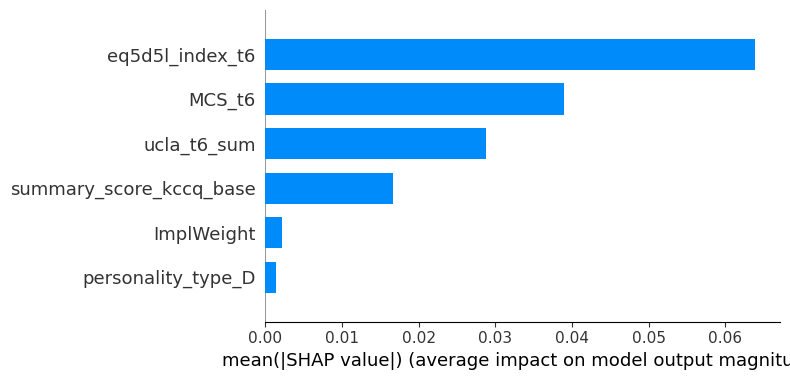

In [80]:
shap.summary_plot(shap_values_test, X_val_imputed, plot_type="bar")

### Beeswarm plot

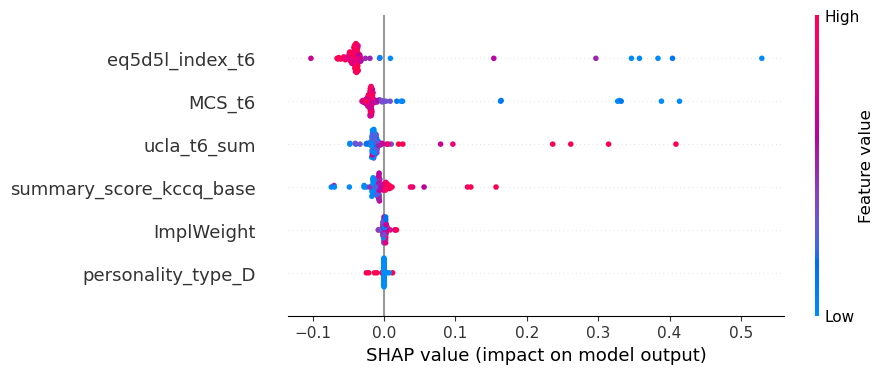

In [81]:
shap.plots.beeswarm(shap_values_test)

## Force plots of Stacking on Anxiety

In [82]:
shap.initjs() #Running shap.initjs() is necessary for creating force plots

### Calculating SHAP Values

In [83]:
import warnings

# Suppressing all warnings
warnings.filterwarnings('ignore')

explainer = shap.KernelExplainer(stacking_clf.predict_proba, X_train_imputed)
shap_values = explainer.shap_values(X_val_imputed)

Using 382 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/96 [00:00<?, ?it/s]

### Identifying interesting samples to observe

In [84]:
counter=0
test = 0
false_pos = False
false_neg = False
neg_sum=0
pos_sum=0
neg_counter=0
pos_counter=0
# For-loop to find different types of samples that may be interesting to observe
for i in range(len(y_val_fold)):
    test = explainer.expected_value[1]+sum(shap_values[i][:,1])
    if y_val_fold[i]==1:
         print("Positive in data", counter, test)
    if test<0.50:
        if y_val_fold[i]==1:
            print("False Negative", counter, test)
            false_neg = True
    if test >0.50:
        if y_val_fold[i]==0:
            print("False Positive", counter, test)
            false_pos = True
    if test>0.10:
        if y_val_fold[i]==0:            
            if false_pos == False:  
                print("True negative near boundary", counter, test)
    if y_val_fold[i]==0:
        if false_pos == False:
            neg_sum = neg_sum+test
            neg_counter +=1
    if y_val_fold[i]==1:
        if false_neg == False:
            pos_sum = pos_sum+test
            pos_counter +=1
        
    counter +=1
    false_pos = False
    false_neg = False

print("Negative sum", neg_sum/neg_counter) # Calculating the average probability / certainty across all the negative samples
print("Positive sum", pos_sum/pos_counter) # Calculating the average probability / certainty across all the positive samples
y_val_fold

False Positive 8 0.8852101142240769
Positive in data 21 0.8558577558656348
Positive in data 25 0.8726633489584112
Positive in data 31 0.7727437189359878
Positive in data 44 0.017382574544027703
False Negative 44 0.017382574544027703
Positive in data 46 0.8935185459011101
Positive in data 83 0.8932448167586133
Positive in data 94 0.6929648133490829
Negative sum 0.018898275363127322
Positive sum 0.8301654999614733


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0])

### True negative - Sample 3

In [85]:
shap.force_plot(explainer.expected_value[1], shap_values[3][:,1], X_val_imputed.iloc[3, :]) 

### True negative - Sample 10

In [86]:
shap.force_plot(explainer.expected_value[1], shap_values[10][:,1], X_val_imputed.iloc[10, :]) 

### True Positive - Sample 46

In [87]:
shap.force_plot(explainer.expected_value[1], shap_values[46][:,1], X_val_imputed.iloc[46, :]) 

### True Positive - Sample 83

In [88]:
shap.force_plot(explainer.expected_value[1], shap_values[83][:,1], X_val_imputed.iloc[83, :]) 

### True Positive near boundary - Sample 31

In [89]:
shap.force_plot(explainer.expected_value[1], shap_values[31][:,1], X_val_imputed.iloc[31, :]) 

### True Positive near boundary - Sample 94

In [90]:
shap.force_plot(explainer.expected_value[1], shap_values[94][:,1], X_val_imputed.iloc[94, :]) 

### False Negative - Sample 44

In [91]:
shap.force_plot(explainer.expected_value[1], shap_values[44][:,1], X_val_imputed.iloc[44, :]) 

### False Positive - Sample 8

In [92]:
shap.force_plot(explainer.expected_value[1], shap_values[8][:,1], X_val_imputed.iloc[8, :]) 

# LGBM on Distress dataset

## Defining the model

In [97]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier

# Defining the preprocessing steps
scaler = MinMaxScaler()
imputer = SimpleImputer()

# Defining stratified k-fold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Using the best parameters
params = {
    'boosting_type': 'dart',
    'class_weight': None,
    'colsample_bytree': 0.7,
    'learning_rate': 0.2,
    'max_depth': 2,
    'n_estimators': 87,
    'num_leaves': 3,
    'objective': 'binary'
}
model = LGBMClassifier(**params, random_state=42, verbose=-1)

# Extracting the folds
f1_macro, f1_class_0, f1_class_1, X_train_fold, X_val_fold, y_train_fold, y_val_fold, X_train_imputed, X_val_imputed  = fold_analyzer(model, scaler, imputer, X_dis_selected, y_dis, fold=1)

# Adding the column names again
X_train_imputed = pd.DataFrame(data=X_train_imputed, columns = X_dis_selected.columns)
X_val_imputed = pd.DataFrame(data=X_val_imputed, columns = X_dis_selected.columns)

F1_macro for fold 1: 0.8636363636363636
F1_class_0 for fold 1: 0.9772727272727273
F1_class_1 for fold 1: 0.75
F1_macro for fold 2: 0.9638418079096045
F1_class_0 for fold 2: 0.9943502824858758
F1_class_1 for fold 2: 0.9333333333333333
F1_macro for fold 3: 0.9318181818181819
F1_class_0 for fold 3: 0.9886363636363636
F1_class_1 for fold 3: 0.875
F1_macro for fold 4: 0.8761408083441982
F1_class_0 for fold 4: 0.9830508474576272
F1_class_1 for fold 4: 0.7692307692307693
F1_macro for fold 5: 1.0
F1_class_0 for fold 5: 1.0
F1_class_1 for fold 5: 1.0
Manually extracted fold F1_macro: 0.8636363636363636


In [98]:
# Fitting the model on the data
model.fit(X_train_imputed, y_train_fold) # Fitting the model

LGBMClassifier(boosting_type='dart', colsample_bytree=0.7, learning_rate=0.2,
               max_depth=2, n_estimators=87, num_leaves=3, objective='binary',
               random_state=42, verbose=-1)

## Global SHAP

### Calculating SHAP Values

In [99]:
import warnings

# Suppressing all warnings
warnings.filterwarnings('ignore')

explainer_test = shap.Explainer(model.predict, X_train_imputed)
shap_values_test = explainer_test(X_val_imputed)

### Bar plot

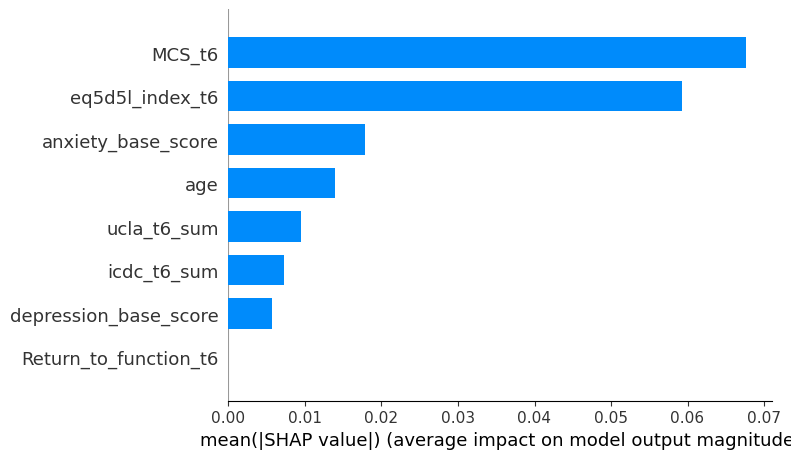

In [100]:
shap.summary_plot(shap_values_test, X_val_imputed, plot_type="bar")

### Beeswarm plot

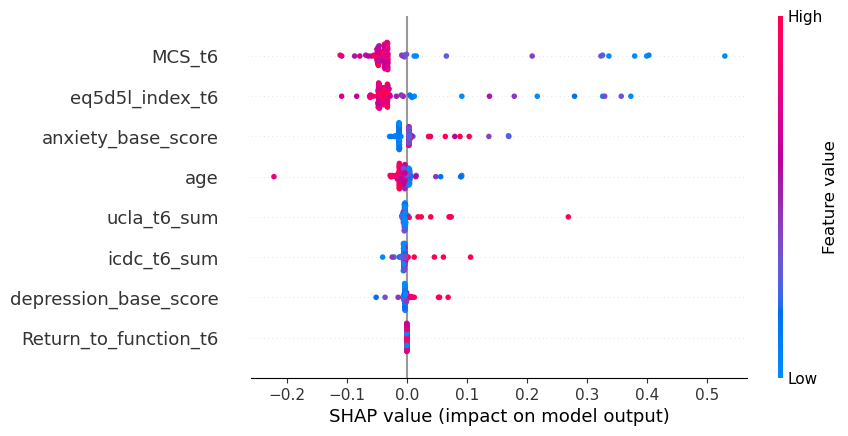

In [101]:
shap.plots.beeswarm(shap_values_test)

## Force plots of LGBM on Distress

In [ ]:
shap.initjs() #Running shap.initjs() is necessary for creating force plots

### Calculating SHAP Values

In [102]:
import shap
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

explainer = shap.KernelExplainer(model.predict_proba, X_train_imputed)
shap_values = explainer.shap_values(X_val_imputed)

Using 382 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/96 [00:00<?, ?it/s]

### Identifying interesting samples to observe

In [103]:
counter=0
test = 0
false_pos = False
false_neg = False
neg_sum=0
pos_sum=0
neg_counter=0
pos_counter=0
# For-loop to find different types of samples that may be interesting to observe
for i in range(len(y_val_fold)):
    test = explainer.expected_value[1]+sum(shap_values[i][:,1])
    if y_val_fold[i]==1:
         print("Positive in data", counter, test)
    if test<0.50:
        if y_val_fold[i]==1:
            print("False Negative", counter, test)
            false_neg = True
    if test >0.50:
        if y_val_fold[i]==0:
            print("False Positive", counter, test)
            false_pos = True
    if test>0.10:
        if y_val_fold[i]==0:            
            if false_pos == False:  
                print("True negative near boundary", counter, test)
    if y_val_fold[i]==0:
        if false_pos == False:
            neg_sum = neg_sum+test
            neg_counter +=1
    if y_val_fold[i]==1:
        if false_neg == False:
            pos_sum = pos_sum+test
            pos_counter +=1
        
    counter +=1
    false_pos = False
    false_neg = False

print("Negative sum", neg_sum/neg_counter) # Calculating the average probability / certainty across all the negative samples
print("Positive sum", pos_sum/pos_counter) # Calculating the average probability / certainty across all the positive samples
y_val_fold

Positive in data 1 0.9262045298424677
Positive in data 19 0.166490805722393
False Negative 19 0.166490805722393
Positive in data 27 0.9087665519782124
True negative near boundary 44 0.4876851198731938
Positive in data 48 0.9588252171671878
Positive in data 51 0.9576459596662036
Positive in data 56 0.9167234024858859
False Positive 61 0.7741635585146412
True negative near boundary 67 0.13721593891924483
False Positive 77 0.697437688996721
True negative near boundary 80 0.30013408509233874
True negative near boundary 86 0.11529921145888909
Positive in data 88 0.05455690170009819
False Negative 88 0.05455690170009819
Positive in data 94 0.541898745155
Negative sum 0.019923880179646643
Positive sum 0.8683440677158262


array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0])

### True Negative - Sample 0

In [104]:
shap.force_plot(explainer.expected_value[1], shap_values[0][:,1], X_val_imputed.iloc[0, :]) 

### True Negative - Sample 12

In [105]:
shap.force_plot(explainer.expected_value[1], shap_values[12][:,1], X_val_imputed.iloc[12, :]) 

### True Negative near boundary - Sample 44

In [106]:
shap.force_plot(explainer.expected_value[1], shap_values[44][:,1], X_val_imputed.iloc[44, :]) 

### True Negative near boundary - Sample 80

In [107]:
shap.force_plot(explainer.expected_value[1], shap_values[80][:,1], X_val_imputed.iloc[80, :]) 

### True Positive - Sample 48

In [108]:
shap.force_plot(explainer.expected_value[1], shap_values[48][:,1], X_val_imputed.iloc[48, :]) 

### True Positive - Sample 51

In [109]:
shap.force_plot(explainer.expected_value[1], shap_values[51][:,1], X_val_imputed.iloc[51, :]) 

### False Negative - Sample 19

In [110]:
shap.force_plot(explainer.expected_value[1], shap_values[19][:,1], X_val_imputed.iloc[19, :]) 

### False Negative - Sample 88

In [111]:
shap.force_plot(explainer.expected_value[1], shap_values[88][:,1], X_val_imputed.iloc[88, :]) 

### False Positive - Sample 61

In [112]:
shap.force_plot(explainer.expected_value[1], shap_values[61][:,1], X_val_imputed.iloc[61, :]) 

### False Positive - Sample 77

In [113]:
shap.force_plot(explainer.expected_value[1], shap_values[77][:,1], X_val_imputed.iloc[77, :]) 